# Rectification

In [1]:
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl        # plotting

import sys # system library
sys.path.append('./lib_nn') 

from neural import * # import my library package

Invoking __init__.py for neural


In [2]:
def fi(x):
    return 0.2+0.8*np.sin(x)+0.5*x-3 # some function

def data(): 
    x = 7.*np.random.rand() # random x coordinate
    y = fi(x)+0.4*func.rn() # y coordinate = the function + noise from [-0.2,0.2]
    return [x,y]

In [3]:
tab=np.array([data() for i in range(200)])    # data sample
features=np.delete(tab,1,1)                   # x coordinate
labels=np.delete(tab,0,1)                     # y coordinate

In the previous chapter we made a hump function from two sigmoids, which would form a basis function for approximation. We may now ask a follow-up question: can we make the sigmoid itself a linear combination (or simply difference) of some other functions. Then we could use these functions for activation of neurons in place of the sigmoid. The answer is yes. For instance, the **Rectified Linear Unit (ReLU)** function 

$$
{\rm ReLU}(x) = \left \{ \begin{array}{l} x {\rm ~~~ for~} x \ge 0 \\
                                          0 {\rm ~~~ for~} x < 0 \end{array}    \right . = {\rm max}(x,0)
$$

does (approximately) the job. The somewhat awkward name comes from electonics, where a "rectifying" (straightening up) unit is used to cut off negative values of an electric signal. The plot of ReLU looks as follows:   

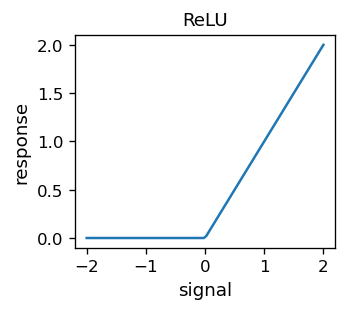

In [4]:
plt.show(draw.plot(func.relu,title='ReLU'))

Taking a difference of two ReLU functions with shifted arguments yields, for example, 

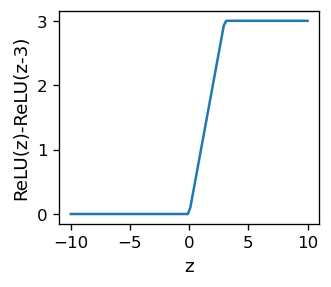

In [5]:
plt.figure(figsize=(2.8,2.3),dpi=120)

s = np.linspace(-10, 10, 100)

fs = [func.relu(z)-func.relu(z-3) for z in s]
plt.plot(s, fs)

plt.xlabel('z',fontsize=11)
plt.ylabel('ReLU(z)-ReLU(z-3)',fontsize=11)
plt.show()

which looks pretty much as a sigmoid, apart from the sharp corners. One can make things smooth by taking a different function, the **softplus**,

$$
{\rm softplus}(x)=\log \left( 1+e^x \right ),
$$
which looks like

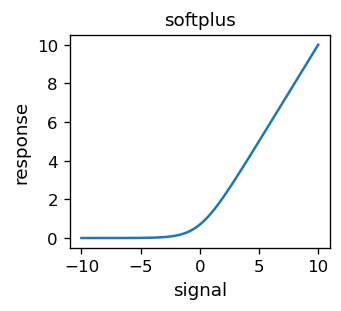

In [6]:
plt.show(draw.plot(func.softplus,title='softplus',start=-10,stop=10))

A difference of two **softplus** functions yields a result very similar to the sigmoid. 

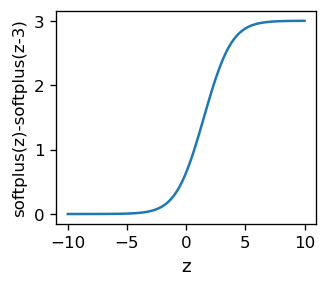

In [7]:
plt.figure(figsize=(2.8,2.3),dpi=120)

s = np.linspace(-10, 10, 100)

fs = [func.softplus(z)-func.softplus(z-3) for z in s]
plt.plot(s, fs)

plt.xlabel('z',fontsize=11)
plt.ylabel('softplus(z)-softplus(z-3)',fontsize=10)
plt.show()

```{note}
One may use the ReLU of softplus, or a plethora of other similar functions, for the activation. 
```

Why one should actually do this will be dicussed later. 

## Interpolation with ReLU

We can approximate our simulated data with an ANN with ReLU acivation in the intermediate layers (and the identity function is the output layer, as in the previous section). The functions are taken from the module **func**.

In [8]:
fff=func.relu    # short-hand notation
dfff=func.drelu

The network must now have more neurons, as the sigmoid "splits" into two ReLU functions:

In [9]:
arch=[1,30,1]                   # architecture
weights=func.set_ran_w(arch, 5) # initialize weights randomly in [-2.5,2.5]

We carry the simulations exactly as in the previous case. Experience says one should stat with small learning speeds. Two sets of rounds (as in the previous chapter)

In [10]:
eps=0.0003         # small learning speed
for k in range(30): # rounds
    for p in range(len(features)):          # loop over the data sample points
        pp=np.random.randint(len(features)) # random point
        func.back_prop_o(features,labels,pp,arch,weights,eps,
                         f=fff,df=dfff,fo=func.lin,dfo=func.dlin) # teaching

In [11]:
for k in range(600): # rounds
    eps=eps*.995
    for p in range(len(features)): # points in sequence
        func.back_prop_o(features,labels,p,arch,weights,eps,
                         f=fff,df=dfff,fo=func.lin,dfo=func.dlin) # teaching

yield the result

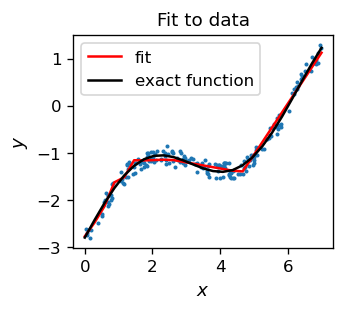

In [12]:
coo=np.linspace(0,7,25)
exact=[fi(x) for x in coo]
res=[func.feed_forward_o(arch, weights, [x], ff=fff, ffo=func.lin)[2][0] for x in coo]

plt.figure(figsize=(2.8,2.3),dpi=120)

plt.title("Fit to data",fontsize=11) 
plt.scatter(features,labels,s=2)


plt.plot(coo,res,c='red',label='fit')
plt.plot(coo,exact,c='black',label='exact function')

plt.legend(prop={'size':10})

plt.xlabel('$x$',fontsize=11)
plt.ylabel('$y$',fontsize=11)
plt.show()

We obtain again a quite satisfactory result (red line), noticing that the plot of the fitting function is a sequence of straight lines, simply reflecting the features of the ReLU activation function.

##  Classifiers with rectification

There are technical reasons in favor of using [rectified functions](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) rather than sigmoid-like ones in backprop. The derivatives of the sigmoid are very close to zero apart for the narrow region near the threshold. This makes updating the weights unlikely, especially when going many layers back, as then very small numbers multiply yielding essentially no update (this is known as the **vanishing gradient problem**). With rectified functions, the range where the derivative is large is big (for ReLU it holds for all positive coordinates), hence the problem is cured. For that reason, rectified functions are used in deep ANNs, where there are many layers, impossible to train when the activation function is of a sigmoid type. 

```{note}
Application of rectified activation functions was one of the key tricks that allowed a breakthrough in deep ANNs around 2011.
```

On the other hand, with ReLU it may happen that some weights are set to such values that many neurons become inactive, i.e. never fire for any input, and so are effectively eliminated. This is known as the "dead neuron" or "dead body" problem, which arises especially when the learning speed parameter is too high. A way to reduce the problem is to use an activation function which does not have at all a range with zero derivative, such as the [Leaky ReLU](https://en.wikipedia.org/wiki/Activation_function). Here we take it in the form 

$$
{\rm Leaky~ReLU}(x) = \left \{ \begin{array}{ll} x &{\rm ~~~ for~} x \ge 0 \\
                                          0.1 \, x &{\rm ~~~ for~} x < 0 \end{array}    \right . .
$$



For illustration, we repeat our example from section {ref}`circ-lab` with the classification of points in the circle, now with Leaky ReLU.

In [13]:
def cir():
    x1=np.random.random() # coordinate 1
    x2=np.random.random() # coordinate 2
    if((x1-0.5)**2+(x2-0.5)**2 < 0.4*0.4): # inside the circle of radius 0.4
                                            # centered at (0.5,0.5)
        return np.array([x1,x2,1])
    else:                                              # outside
        return np.array([x1,x2,0])


In [14]:
sample_c=np.array([cir() for _ in range(1000)]) # sample
features_c=np.delete(sample_c,2,1)
labels_c=np.delete(np.delete(sample_c,0,1),0,1)

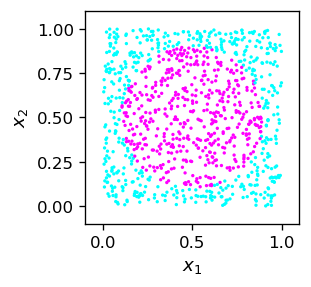

In [15]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(sample_c[:,0],sample_c[:,1],c=sample_c[:,2],
            s=1,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

We take the following architecture and initial parameters:

In [16]:
arch_c=[2,20,1]                   # architecture
weights=func.set_ran_w(arch_c,3)  # scaled random initial weights in [-1.5,1.5]
eps=.01                           # initial learning speed 

and run the algorithm in two stages: with Leaky ReLU, and then with ReLU.  

In [17]:
for k in range(300):    # rounds
    eps=.9999*eps       # decrease the learning speed
    if k%100==99: print(k+1,' ',end='')             # print progress        
    for p in range(len(features_c)):                # loop over points
        func.back_prop_o(features_c,labels_c,p,arch_c,weights,eps,
            f=func.lrelu,df=func.dlrelu,fo=func.sig,dfo=func.dsig) 
                    # backprop with leaky ReLU

100  200  300  

In [18]:
for k in range(700):    # rounds
    eps=.9999*eps       # decrease the learning speed
    if k%100==99: print(k+1,' ',end='')             # print progress        
    for p in range(len(features_c)):                # loop over points
        func.back_prop_o(features_c,labels_c,p,arch_c,weights,eps,
            f=func.relu,df=func.drelu,fo=func.sig,dfo=func.dsig) 
                    # backprop with ReLU

100  200  300  400  500  600  700  

The result is quite satisfactory, showing that the method works. With the present architecture and activation functions, not surprisingly, in the plot below we can notice traces of a polygon approximating the circle. 

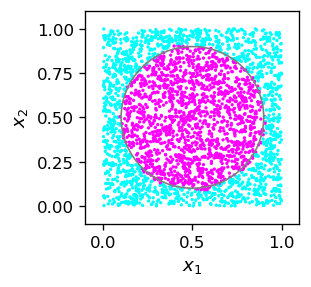

In [19]:
test=[] 

for k in range(3000):
    po=[np.random.random(),np.random.random()] 
    xt=func.feed_forward_o(arch_c,weights,po,ff=func.relu,ffo=func.sig)   
    test.append([po[0],po[1],np.round(xt[len(arch_c)-1][0],0)])

tt=np.array(test)

fig=plt.figure(figsize=(2.3,2.3),dpi=120)

# drawing the circle
ax=fig.add_subplot(1,1,1)
circ=plt.Circle((0.5,0.5), radius=.4, color='gray', fill=False)
ax.add_patch(circ)

plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(tt[:,0],tt[:,1],c=tt[:,2],
            s=1,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

## Exercises

```{admonition} $~$
:class: warning

1. Use various rectified activation functions for the binary classifiers and test them on various shapes (in analogy to the example with the circle above).

2. Convince yourself that starting backprop (with ReLU) with a too large initial learning speed leads to a "dead neuron" problem and a failure of the algorithm. 

```